In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from thinning import sample_hawkes_process_thinning, sample_hawkes_process_thinning_vectorised, sample_hawkes_process_thinning_true_vectorised
from utils import exp_kernel, constant_background, plot_counting_process, exp_kernel_vectorised
from time_rescaling import rescale_times, rescale_times_true_vectorised
from clustering import simulate_homogeneous_poisson_process, simulate_inhomogeneous_poisson_process, simulate_immigrants, simulate_offspring, produce_cluster, sample_hawkes_process_clustering, cluster_plot

In [3]:
from utils import conditional_intensity, conditional_intensity_vectorised, conditional_intensity_true_vectorised

## Simulation with thinning 

Usage:

In [4]:
max_T = 1000

hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised)

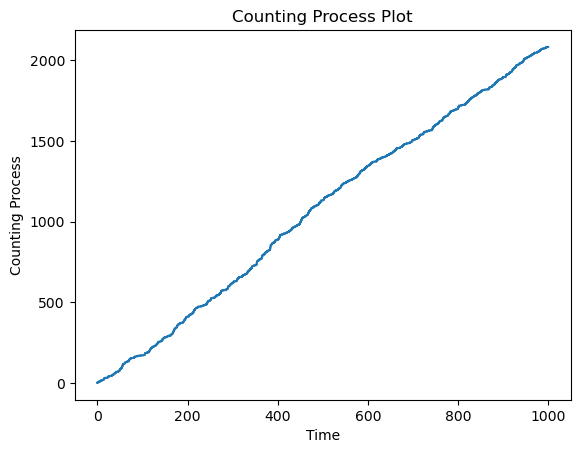

In [5]:
plot_counting_process(hawkes_realisation)

Using constant background, we expect number of immigrants equal to max_T. (Here = 1000.)

Using exponential kernel, we expect branching factor to be $\alpha/\delta$ and so cluster size is $\frac{1}{1-\alpha/\delta} = \frac{\delta}{\delta-\alpha}$. (Here = 2.)

Thus here we expect roughly 2000 events. Let's simulate this multiple times.

In [6]:
max_T = 1000

num_samples = 100
num_events = np.zeros(num_samples)
for i in range(num_samples):
    hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised)
    num_events[i] = len(hawkes_realisation)

print(np.mean(num_events))

2005.93


Very close to 2000, so good!

In [15]:
def zero_kernel(t):

    return np.zeros_like(t)

In [16]:
max_T = 1000

num_samples = 100
num_events = np.zeros(num_samples)
for i in range(num_samples):
    hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, zero_kernel)
    num_events[i] = len(hawkes_realisation)

print(np.mean(num_events))

1001.76


Here we make the kernel zero so that it reduces to a Poisson process (homogeneous since constant background) and find the right expected number of events again.

### Time-rescaling

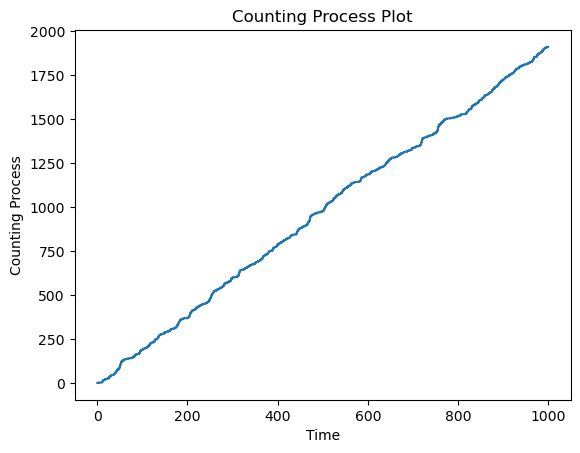

In [28]:
max_T = 1000

hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised)
plot_counting_process(hawkes_realisation)

In [29]:
taus = rescale_times(hawkes_realisation)

c:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\utils.py:40: RuntimeWarning: overflow encountered in exp
  return np.where(t < 0, 0, alpha * np.exp(-delta * t))


In [30]:
z_list = [(1 - np.exp(-tau)) for tau in taus]

(array([1.02171747, 0.98504043, 1.08983197, 1.02171747, 1.05315493,
        0.84881144, 0.92740509, 0.97456128, 1.08459239, 0.99551959]),
 array([0.        , 0.09997648, 0.19995297, 0.29992945, 0.39990594,
        0.49988242, 0.59985891, 0.69983539, 0.79981188, 0.89978836,
        0.99976485]),
 <BarContainer object of 10 artists>)

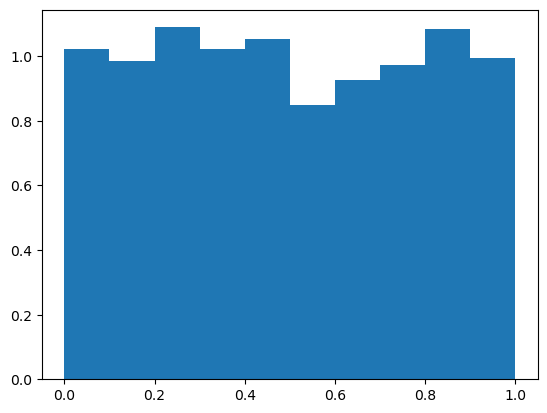

In [31]:
plt.hist(z_list, bins=10, density=True)

In [32]:
taus2 = rescale_times_true_vectorised(hawkes_realisation)

Why is there an overflow warning??

In [33]:
z2 = [(1 - np.exp(-tau)) for tau in taus2]

(array([1.02171747, 0.98504043, 1.08983197, 1.02171747, 1.05315493,
        0.84881144, 0.92740509, 0.97456128, 1.08459239, 0.99551959]),
 array([0.        , 0.09997648, 0.19995297, 0.29992945, 0.39990594,
        0.49988242, 0.59985891, 0.69983539, 0.79981188, 0.89978836,
        0.99976485]),
 <BarContainer object of 10 artists>)

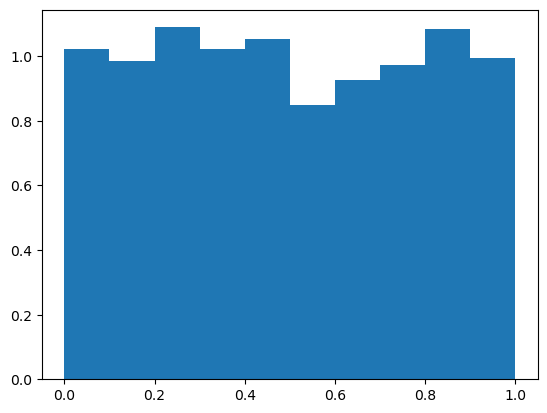

In [34]:
plt.hist(z2, bins=10, density=True)

Code works the same and is quicker using true_vectorised.

In [35]:
np.allclose(taus, taus2)

True

In [36]:
import statsmodels.api as sm

In [37]:
import scipy

(https://stackoverflow.com/questions/13865596/quantile-quantile-plot-using-scipy)

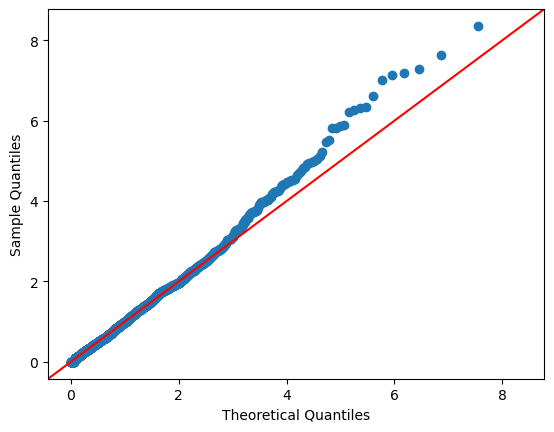

In [38]:
sm.qqplot(np.array(taus2), line='45', dist=scipy.stats.distributions.expon)
plt.show()

Upper quantiles fall off because of edge effects.

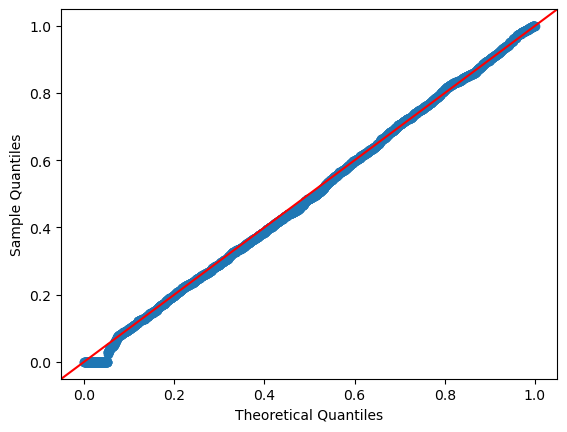

In [39]:
sm.qqplot(np.array(z2), line='45', dist=scipy.stats.distributions.uniform)
plt.show()

QQ plots look good (on uniform plot, points close to 0 lie on horizontal line, is this OK?) Wait - think this is also edge effects.

From this we conclude `sample_hawkes_process_thinning_true_vectorised` works properly!

### MLE

Quick code check

In [4]:
a = np.array([1,2,5,15])
max_T = 7

mask = (a < 7)

b = np.exp(a)
b = np.where(mask, b, 0)
np.sum(b)

158.5204970299663

In [5]:
a = a[np.newaxis, :]

In [6]:
a.T - a

array([[  0,  -1,  -4, -14],
       [  1,   0,  -3, -13],
       [  4,   3,   0, -10],
       [ 14,  13,  10,   0]])

In [7]:
differences_from_max = max_T - a
differences_from_max

array([[ 6,  5,  2, -8]])

In [8]:
summands = np.exp(-3*differences_from_max) - 1

In [9]:
mask = differences_from_max > 0

In [10]:
summands * mask

array([[-0.99999998, -0.99999969, -0.99752125,  0.        ]])

In [11]:
differences_from_max = np.where(differences_from_max>0, differences_from_max, 0)

In [12]:
differences_from_max

array([[6, 5, 2, 0]])

In [13]:
differences_mat = np.tril(a.T - a)
differences_mat

array([[ 0,  0,  0,  0],
       [ 1,  0,  0,  0],
       [ 4,  3,  0,  0],
       [14, 13, 10,  0]])

In [14]:
np.sum(np.tril(np.exp(-3*differences_mat), k=-1), axis=1)

array([0.00000000e+00, 4.97870684e-02, 1.29554016e-04, 9.35883529e-14])

In [15]:
np.log(1 + np.sum(np.tril(np.exp(differences_mat), k=-1), axis=1))

array([ 0.        ,  1.31326169,  4.32656264, 14.32656324])

From Ettie's code

${log L = \sum_{i = 1}^{n} log (\mu(t_{i}) + \sum_{t_{i} - t_{j}} g(t_{i} - t_{j})) -\int_{0}^{T} \mu(t_{i}) d\tau - \sum_{i=1}^{n} \int_{t_{i}}^{T} g(\tau - t_{i}) d\tau}$

In [4]:
from mle import log_likelihood, old_log_likelihood

In [5]:
params = 3, 1, 2
data = [3,4,5], 6

In [6]:
log_likelihood(params, data)

19.421935162848992


-16.032025952827766

In [7]:
old_log_likelihood(params, data)

array([-12719.11837238])

In [8]:
from time_rescaling import integrate_conditional_intensity_true_vectorised

In [9]:
integrate_conditional_intensity_true_vectorised(0, 6, [3,4,5], constant_background, exp_kernel_vectorised)

7.416913112461554

In [10]:
t_values = np.linspace(0,6, 600)

In [11]:
conditional_intensity_values = conditional_intensity_true_vectorised(t_values, [3,4,5], constant_background, exp_kernel_vectorised)

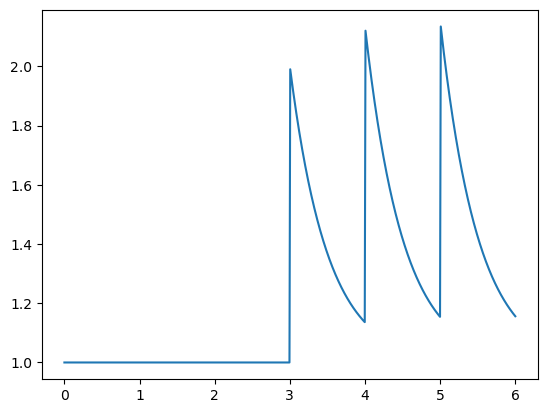

In [12]:
plt.plot(t_values, conditional_intensity_values)

In [13]:
np.trapz(conditional_intensity_values, t_values)

7.416913112461554

In [14]:
log_likelihood((1,1,2), ([3,4,5], 6))

7.421935162848993


-7.152075523306121

Compare old and vectorised - matching outputs! (Did find big error with -1 term not being outside of exp bracket in old code)

Now try to do MLE

In [15]:
from scipy.optimize import minimize

In [16]:
hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(100, constant_background, exp_kernel_vectorised)

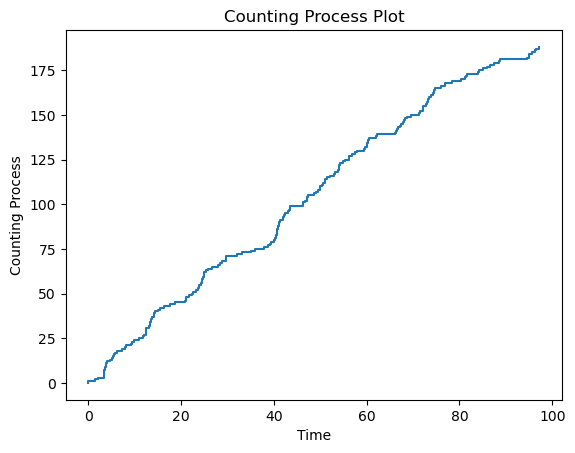

In [17]:
plot_counting_process(hawkes_realisation)

In [18]:
data = hawkes_realisation, 100

In [20]:
# Initial guess for the parameters
initial_guess = [1, 0.5, 1]
epsilon = 1e-10
bounds = ((epsilon, None), (epsilon, None), (epsilon, None))

print(log_likelihood(initial_guess, data))

# Minimize the negative log-likelihood
result = minimize(lambda params: -log_likelihood(params, data), initial_guess, bounds=bounds)

# Extract the optimized parameters
optimized_params = result.x

print("Optimized Parameters:")
print("mu:", optimized_params[0])
print("alpha:", optimized_params[1])
print("delta:", optimized_params[2])

193.92694483959767
14.868850183570032
193.92694483959767
193.92694583959766
193.92694671813658
193.9269439028962
126.39361625489738
126.39361725489738
126.39362183851438
126.39361350590826
1.0738362109016696e-06
2.0738362109016693e-06
0.00010745745730106862
1.0738358401388433e-06
126.39357324727325
126.39357424727325
126.39357883089701
126.39357049828081
100.93621307994505
100.93621407994505
100.93622924860777
100.93620551222139
79.23077648644825
79.23077748644825
79.2308172719351
79.2307621034804
1.0738362109016696e-06
2.0738362109016693e-06
0.00010745745730106862
1.0738358401388433e-06
64.28439538522522
64.28439638522524
64.28450176884631
64.28439538522485
21.428129156356224
21.428130156356225
21.42823553997731
21.42812915635585
7.132005271018804
7.132006271018804
7.132111654639894
7.132005271018433
2.373774650409512
2.373775650409512
2.373881034030602
2.3737746504091413
0.7900754365662761
0.7900764365662761
0.7901818201873663
0.7900754365659053
0.26296695791970426
0.2629679579197042

In [21]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -789.2068529751599
        x: [ 1.061e-02  1.000e-10  1.000e-10]
      nit: 22
      jac: [-2.160e-04  1.064e+04  4.245e+03]
     nfev: 172
     njev: 43
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

## Simulation with clustering

Usage:

In [33]:
max_T = 1000

hawkes_realisation = sample_hawkes_process_clustering(max_T)

In [34]:
hawkes_realisation

{0: {0: [0.31383196516936324]},
 1: {0: [0.7888534154550609], 1: [1.9335570135775364]},
 2: {0: [1.585907376167851]},
 3: {0: [1.7118528586197643], 1: [1.9111179212143892]},
 4: {0: [1.747751211046328]},
 5: {0: [4.259690896486794],
  1: [4.72100409059573,
   4.754099810076915,
   5.007486658551257,
   5.048017042768553],
  2: [4.935388439548427, 5.365241210728888],
  3: [5.799104550751798]},
 6: {0: [7.061501109691854], 1: [7.4457779517503235]},
 7: {0: [8.615740447276192]},
 8: {0: [8.85481421328343]},
 9: {0: [9.082676011009406],
  1: [9.59461948689699],
  2: [10.222164404043529, 11.319576591637526]},
 10: {0: [10.334627620655136]},
 11: {0: [13.122595413537557], 1: [13.218547191137656]},
 12: {0: [13.140364943880327]},
 13: {0: [13.307098118874823]},
 14: {0: [13.982530952838708]},
 15: {0: [15.039181755062287], 1: [15.1225165931884]},
 16: {0: [15.335670653886448]},
 17: {0: [15.967373002555135],
  1: [16.06074732409783, 16.745051844133638, 16.777125823953877],
  2: [16.7553406498

In [35]:
sum = 0
for cluster in hawkes_realisation.values():
    for lst in cluster.values():
        sum += len(lst)
print(sum)

1975
